# Lab 3: Classification (Part 2) and Model Selection

## Name: Yashas Bhushappagala (yab2)

### Due September 18, 2019 11:59 PM

**Logistics and Lab Submission**

See the [course website](https://courses.engr.illinois.edu/ece365/fa2019/logisticsvvv.html). Remember that all labs count equally, despite the labs being graded from a different number of total points).

**What You Will Need To Know For This Lab**

This lab covers a few more basic classifiers which can be used for M-ary classification:
- Naive Bayes
- Logistic Regression
- Support Vector Machines

as well as cross-validation, a tool for model selection and assessment.
 
There are some problems which have short answer questions. <b>Do not write an essay -- a few (1-2) complete sentences will suffice.</b>

<b>Also, be clear about your answers</b>. For example, if a question asks you "Which classifier would you choose?", be unequivocal about which classifier you would choose (and why); as engineers, part of your job is to make design decisions and justify them in the context of the alternatives and in the application. 

Remember in many applications, the end goal is not always "run a classifier", like in a homework problem, but is to use the output of the classifier in the context of the problem at hand (e.g. detecting spam, identifying cancer, etc.). Because of this, some of our Engineering Design-type questions are designed to get you to think about the entire design problem at a high level.


**Warning: Do not train on your test sets. You will automatically have your score halved for a problem if you train on your test data.**

**Preamble (don't change this)**

In [1]:
%pylab inline
import numpy as np
from sklearn import neighbors
from sklearn import svm
from sklearn import model_selection
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
import glob

Populating the interactive namespace from numpy and matplotlib


### Problem 1: Spam Detection (90 points)

In this problem, you will be constructing a crude spam detector. As you all know, when you receive an e-mail, it can be divided into one of two types: ham (useful mail, label $-1$) and spam (junk mail, label $+1$). In the [olden days](http://www.paulgraham.com/spam.html), people tried writing a bunch of rules to detect spam. However, it was quickly seen that machine learning approaches work fairly well for a little bit of work. 

You will be designing a spam detector by applying some of the classification techniques you learned in class to a batch of emails used to train and test [SpamAssassin](http://spamassassin.apache.org/), a leading anti-spam software package. 

Let the *vocabulary* of a dataset be a list of all terms occuring in a data set. So, for example, a vocabulary could be ["cat","dog","chupacabra", "aerospace", ...]. 

Our features will be based only the frequencies of terms in our vocabulary occuring in the e-mails (such an approach is called a *bag of words* approach, since we ignore the positions of the terms in the emails). The $j$-th feature is the number of times term $j$ in the vocabulary occurs in the email. If you are interested in further details on this model, you can see Chapters 6 and 13 in [Manning's Book](http://nlp.stanford.edu/IR-book/).

You will use the following classifiers in this problem:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (1-Nearest Neighbor Classifier)

In the context of the Bernoulli Model for Naive Bayes, scikit-learn will binarize the features by interpretting the $j$-th feature to be $1$ if the $j$-th term in the vocabulary occurs in the email and $0$ otherwise. This is a categorical Naive Bayes model, with binary features. While we did not discuss the multinomial model in class, it operates directly on the frequencies of terms in the vocabulary, and is discussed in Section 13.2 in [Manning's Book](http://nlp.stanford.edu/IR-book/) (though you do not need to read this reference). Both the Bernoulli and Multinomial models are commonly used for Naive Bayes in text classification. 

A sample Ham email is:

    From nic@starflung.com  Mon Jun 24 17:06:54 2002
    Return-Path: 7910726.0.27May2002215326@mp.opensrs.net
    Delivery-Date: Tue May 28 02:53:28 2002
    Received: from mp.opensrs.net (mp.opensrs.net [216.40.33.45]) by
        dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4S1rSe14718 for
        <zzz@spamassassin.taint.org>; Tue, 28 May 2002 02:53:28 +0100
    Received: (from popensrs@localhost) by mp.opensrs.net (8.9.3/8.9.3) id
        VAA04361; Mon, 27 May 2002 21:53:26 -0400
    Message-Id: <7910726.0.27May2002215326@mp.opensrs.net>
    Date: Mon, 27 May 2002 21:53:26 -0500 (EST)
    From: "Starflung NIC" <nic@starflung.com>
    To: <zzz@spamassassin.taint.org>
    Subject: Automated 30 day renewal reminder 2002-05-27
    X-Keywords: 

    The following domains that are registered as belonging
    to you are due to expire within the next 60 days. If
    you would like to renew them, please contact
    nic@starflung.com; otherwise they will be deactivated
    and may be registered by another.


    Domain Name, Expiry Date
    nutmegclothing.com, 2002-06-26
    
    
A sample Spam email is: 

    From jjj@mymail.dk  Fri Aug 23 11:03:31 2002
    Return-Path: <jjj@mymail.dk>
    Delivered-To: zzzz@localhost.example.com
    Received: from localhost (localhost [127.0.0.1])
        by phobos.labs.example.com (Postfix) with ESMTP id 478B54415C
        for <zzzz@localhost>; Fri, 23 Aug 2002 06:02:57 -0400 (EDT)
    Received: from mail.webnote.net [193.120.211.219]
        by localhost with POP3 (fetchmail-5.9.0)
        for zzzz@localhost (single-drop); Fri, 23 Aug 2002 11:02:57 +0100 (IST)
    Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
        by webnote.net (8.9.3/8.9.3) with ESMTP id IAA08912;
        Fri, 23 Aug 2002 08:13:36 +0100
    From: jjj@mymail.dk
    Received: from mymail.dk (unknown [61.97.34.233])
        by smtp.easydns.com (Postfix) with SMTP
        id 7484A2F85C; Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Reply-To: <jjj@mymail.dk>
    Message-ID: <008c61d64eed$6184e5d5$4bc22de3@udnugg>
    To: bbr_hooten@yahoo.com
    Subject: HELP WANTED.  WORK FROM HOME REPS.
    MiME-Version: 1.0
    Content-Type: text/plain;
        charset="iso-8859-1"
    X-Priority: 3 (Normal)
    X-MSMail-Priority: Normal
    X-Mailer: Microsoft Outlook, Build 10.0.2616
    Importance: Normal
    Date: Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Content-Transfer-Encoding: 8bit

    Help wanted.  We are a 14 year old fortune 500 company, that is
    growing at a tremendous rate.  We are looking for individuals who
    want to work from home.

    This is an opportunity to make an excellent income.  No experience
    is required.  We will train you.

    So if you are looking to be employed from home with a career that has
    vast opportunities, then go:

    http://www.basetel.com/wealthnow

    We are looking for energetic and self motivated people.  If that is you
    than click on the link and fill out the form, and one of our
    employement specialist will contact you.

    To be removed from our link simple go to:

    http://www.basetel.com/remove.html


    1349lmrd5-948HyhJ3622xXiM0-290VZdq6044fFvN0-799hUsU07l50



First, we will load the data. Our dataset has a bit over 9000 emails, with about 25% of them being spam. We will use 50% of them as a training set, 25% of them as a validation set and 25% of them as a test set. 

In [2]:
# Get list of emails
spamfiles=glob.glob('./Data/Spam/*')
hamfiles=glob.glob('./Data/Ham/*')

In [3]:
# First, we will split the files into the training, validation and test sets.

np.random.seed(seed=222017) # seed the RNG for repeatability

fnames=np.asarray(spamfiles+hamfiles)
nfiles=fnames.size
labels=np.ones(nfiles)
labels[len(spamfiles):]=-1

# Randomly permute the files we have
idx=np.random.permutation(nfiles)
fnames=fnames[idx]
labels=labels[idx]

#Split the file names into which set they belong to
tname=fnames[:int(nfiles/2)]
trainlabels=labels[:int(nfiles/2)]
vname=fnames[int(nfiles/2):int(nfiles*3/4)]
vallabels=labels[int(nfiles/2):int(nfiles*3/4)]
tename=fnames[int(3/4*nfiles):]
testlabels=labels[int(3/4*nfiles):]

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Get our Bag of Words Features from the data
bow = CountVectorizer(input='filename',encoding='iso-8859-1',binary=False)
traindata=bow.fit_transform(tname)
valdata=bow.transform(vname)
testdata=bow.transform(tename)

The $100$ most and least common terms in the vocabulary are:

In [5]:
counts=np.reshape(np.asarray(np.argsort(traindata.sum(axis=0))),-1)
vocab=np.reshape(np.asarray(bow.get_feature_names()),-1)
print ("100 most common terms: " , ','.join(str(s) for s in vocab[counts[-100:]]), "\n")
print ("100 least common terms: " , ','.join(str(s) for s in vocab[counts[:100]]))

100 most common terms:  slashnull,dogma,click,not,request,ist,exmh,as,thu,wed,jmason,have,cnet,lists,or,are,mon,html,freshrpms,date,mailman,align,message,00,12,users,postfix,text,arial,type,bgcolor,rpm,ie,22,linux,version,be,taint,your,mailto,20,admin,table,sourceforge,content,color,jm,face,on,border,example,127,aug,gif,this,href,10,img,subject,src,09,nbsp,sep,it,that,0100,height,spamassassin,esmtp,is,size,xent,you,fork,tr,in,list,11,www,br,width,received,localhost,id,of,and,org,by,with,for,net,td,font,2002,from,3d,http,to,the,com 

100 least common terms:  ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿó,snd_index,crittenden,vghhbmsgww91iezvcibzb3vyifrpbwusiefu,snd_major,criuqccibiqnijvkpqkraocgwoeadz9qikwzkkxzo94ow8jaq7kza2xlzdpk9fw07swhmk6zfx4k,crjowqpf7aywdqg8cke9fwakiatnugirizcja5ougeakmggdbyyditzrgcracagvtgzb05k6j8,vgh9,crlsbd,crlsca,vgggkvaadjknu,vgfliejvpgjypldvcmtvdxqgncbqywnrpc9ipjxicj4gidxm,cro19c3zkymlwxiwrclxwvnkbo,vgfby5giuasgpjnj9rtm42jaariaaabm77x,croatian,croatians,sndqbqy,c

We will have our training data in `traindata` (with labels in `trainlabels`), validation data in `valdata` (with labels in `vallabels`) and test data in `testdata` (with labels in `testlabels`). The data is stored as a sparse scipy matrix (scipy.sparse.csr.csr_matrix), since we have a decent number of features (~100k), most of which are zero (~0.2% are non-zero), this allows storing the data in a few megabytes. Directly storing it as a numpy array (as we did in lab 1) would take around 8 gigabytes. Working with sparse data can make many algorithms run faster and use less storage. 

Train each of the following classifiers **( 3 Points Each )**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier, report:
- Time it took to fit the classifier (i.e. call the .fit method) **(1 Point Each)**
- Training Error **( 1 Point Each)**

This part of the problem has a total of **25 points**.

In [6]:
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
import time as time

In [7]:
# Put your code here
def classifierError(truelabels,estimatedlabels):
    # Put your code here
    err=0
    for i in range(truelabels.size):
        if truelabels[i]==estimatedlabels[i]:
            err=err+0
        else:
            err=err+1
            
    n=truelabels.size
    errval=err/n
    return errval

bnb=BernoulliNB()
bnbstart=time.time()
bnb.fit(traindata,trainlabels)
bnbend=time.time()
bnbest=bnb.predict(traindata)
print("Training Error for BernoulliNB = ",classifierError(trainlabels,bnbest))
print("Time taken to fit data to BernoulliNB classifier = ",bnbend-bnbstart)

mnb=MultinomialNB()
mnbstart=time.time()
mnb.fit(traindata,trainlabels)
mnbend=time.time()
mnbest=mnb.predict(traindata)
print("Training Error for MultinomialNB = ",classifierError(trainlabels,mnbest))
print("Time taken to fit data to MultinomialNB classifier = ",mnbend-mnbstart)

lsvc=LinearSVC()
lsvcstart=time.time()
lsvc.fit(traindata,trainlabels)
lsvcend=time.time()
lsvcest=lsvc.predict(traindata)
print("Training Error for Linear support vector machine = ",classifierError(trainlabels,lsvcest))
print("Time taken to fit data to Linear support vector machine = ",lsvcend-lsvcstart)

lr=LogisticRegression()
lrstart=time.time()
lr.fit(traindata,trainlabels)
lrend=time.time()
lrest=lr.predict(traindata)
print("Training Error for Logistic regression = ",classifierError(trainlabels,lrest))
print("Time taken to fit data to Logistic regression classifier = ",lrend-lrstart)

knn=KNeighborsClassifier(n_neighbors=1) 
knnstart=time.time()
knn.fit(traindata,trainlabels)
knnend=time.time()
knnest=knn.predict(traindata)
print("Training Error for 1 nearest neighbour = ",classifierError(trainlabels,knnest))
print("Time taken to fit data to 1 nearest neighbour classifier = ",knnend-knnstart)






Training Error for BernoulliNB =  0.05541292255027813
Time taken to fit data to BernoulliNB classifier =  0.05486011505126953
Training Error for MultinomialNB =  0.01647411210954215
Time taken to fit data to MultinomialNB classifier =  0.011884927749633789


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Error for Linear support vector machine =  0.0
Time taken to fit data to Linear support vector machine =  0.5197501182556152
Training Error for Logistic regression =  0.0
Time taken to fit data to Logistic regression classifier =  2.0138280391693115
Training Error for 1 nearest neighbour =  0.0
Time taken to fit data to 1 nearest neighbour classifier =  0.003032207489013672


Give a justification as to why the Linear SVM and Logistic regression have their particular value of training error. **(5 points)**

[Insert Your Answer Here]
Linear SVM and Logistic regression both end up being linear classifiers seperating the data into 2 regions. The point being observed is in the same location as something from the training data and hence belongs in the same region and is hence given the same label. Thus, given label is exactly the same as training label and error is 0.

Run each of the classifiers on the validation data **(2 Points Each)**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Multiomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier:
- Store the labels it predicted as \_\_vallabels, where \_\_ is NB,MB,SVM,LR,NN respectively. **( 1 Point Each)**
- Time it took to run the classifier on the data **(1 Point Each)**
- Validation Error **(1 Point Each)**

This part of the problem has a total of **25 points**.

In [8]:
# Put your code here
bnbstart=time.time()
NBvallables=bnb.predict(valdata)
bnbend=time.time()
print("Validation Error for BernoulliNB = ",classifierError(vallabels,NBvallables))
print("Time taken to predict labels by BernoulliNB classifier = ",bnbend-bnbstart)

mnbstart=time.time()
MBvallables=mnb.predict(valdata)
mnbend=time.time()
print("Validation Error for MultinomialNB = ",classifierError(vallabels,MBvallables))
print("Time taken to predict labels by MultinomialNB classifier = ",mnbend-mnbstart)


lsvcstart=time.time()
SVMvallables=lsvc.predict(valdata)
lsvcend=time.time()
print("Validation Error for Linear support vector machine = ",classifierError(vallabels,SVMvallables))
print("Time taken to predict labels by Linear support vector machine = ",lsvcend-lsvcstart)


lrstart=time.time()
LRvallables=lr.predict(valdata)
lrend=time.time()
print("Validation Error for Logistic regression = ",classifierError(LRvallables,vallabels))
print("Time taken to predict labels by Logistic regression classifier = ",lrend-lrstart)

knnstart=time.time()
NNvallables=knn.predict(valdata)
knnend=time.time()
print("Validation Error for 1 nearest neighbour = ",classifierError(NNvallables,vallabels))
print("Time taken to predict labels by 1 nearest neighbour classifier = ",knnend-knnstart)





Validation Error for BernoulliNB =  0.09584937954642704
Time taken to predict labels by BernoulliNB classifier =  0.024533987045288086
Validation Error for MultinomialNB =  0.03123662815575524
Time taken to predict labels by MultinomialNB classifier =  0.008177042007446289
Validation Error for Linear support vector machine =  0.008130081300813009
Time taken to predict labels by Linear support vector machine =  0.0023059844970703125
Validation Error for Logistic regression =  0.008130081300813009
Time taken to predict labels by Logistic regression classifier =  0.002198934555053711
Validation Error for 1 nearest neighbour =  0.017115960633290545
Time taken to predict labels by 1 nearest neighbour classifier =  1.9589450359344482


Let us take a more nuanced look at the type of errors made on a data set. The following function calculates a confusion matrix (Fig. 2.1 in the notes) and some statistics. You may wish to read Section 2.1.1 in the notes -- it may be helpful, but is not necessary to complete this problem.

In [9]:
def ConfMatr(truelabels,estimatedlabels,classifiername):
    # classifiername is a string, such as 'Naive Bayes (Bernoulli)'
    cm=np.zeros((2,2))
    cm[0,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==1)) # True Positives
    cm[0,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==1)) # False Positive
    cm[1,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==-1)) # False Negative
    cm[1,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==-1)) # True Negatives
    print ("Classifier Name: %s"% classifiername )
    print ("True Positives:", cm[0,0], "False Positive:", cm[0,1])
    print ("False Negative:", cm[1,0], "True Negatives:", cm[1,1])
    print ("True Positive Rate : ", cm[0,0]/np.sum(truelabels==1))
    print ("False Positive Rate: ", cm[0,1]/np.sum(truelabels==-1))
    print ("---")

Run ConfMatr using the validation labels and their estimates for all the classifiers we've used in this problem. **(5 points)**

In [10]:
# Put your code here
ConfMatr(vallabels,NBvallables,classifiername='Bernoulli Naive Bayes')
ConfMatr(vallabels,MBvallables,classifiername='Multinomial Naive Bayes')
ConfMatr(vallabels,SVMvallables,classifiername='Linear Support Vector Machine')
ConfMatr(vallabels,LRvallables,classifiername='Logistic Regression')
ConfMatr(vallabels,NNvallables,classifiername='one nearest neighbour')

Classifier Name: Bernoulli Naive Bayes
True Positives: 389.0 False Positive: 11.0
False Negative: 213.0 True Negatives: 1724.0
True Positive Rate :  0.6461794019933554
False Positive Rate:  0.006340057636887608
---
Classifier Name: Multinomial Naive Bayes
True Positives: 538.0 False Positive: 9.0
False Negative: 64.0 True Negatives: 1726.0
True Positive Rate :  0.893687707641196
False Positive Rate:  0.005187319884726225
---
Classifier Name: Linear Support Vector Machine
True Positives: 593.0 False Positive: 10.0
False Negative: 9.0 True Negatives: 1725.0
True Positive Rate :  0.9850498338870431
False Positive Rate:  0.005763688760806916
---
Classifier Name: Logistic Regression
True Positives: 593.0 False Positive: 10.0
False Negative: 9.0 True Negatives: 1725.0
True Positive Rate :  0.9850498338870431
False Positive Rate:  0.005763688760806916
---
Classifier Name: one nearest neighbour
True Positives: 576.0 False Positive: 14.0
False Negative: 26.0 True Negatives: 1721.0
True Positive

What does the True Positive Rate mean for this problem? What does the False Positive Rate mean for this problem? Do we want these quantites to be high, low or don't care? Explain using words (no equations!). **(10 point)**

[Insert Answer Here]
True positive rate is the proportion of positive samples that were correctly identified. In this problem itmeans the proportion of ham emails that were identified as ham by our classifier. We want this to  be very  high!

False  Positive rate is the proportion  of samples  identified as negative even though they were  positive. This is also the proportion of ham mails that were identified as spam by us.We want this to be very low!

Based on the results of this problem and knowledge of the application at hand (spam filtering), pick one of the classifiers in this problem and describe how you would use it as part of a spam filter for the University of Illinois email system. 

Be sure to justify your choice. **(10 points)**

For this problem, just sketch out a system design at a very high level -- how you would train the spam filter to deal with new threats, would you filter everyone's email jointly, etc. We're just looking for around a paragraph on how you would come up with a (very rough) engineering design using the results of this problem. You may get some inspiration from the [girls and boys](https://gmail.googleblog.com/2007/10/how-our-spam-filter-works.html) at [Gmail](https://gmail.googleblog.com/2015/07/the-mail-you-want-not-spam-you-dont.html), the [chimps at MailChimp](http://kb.mailchimp.com/delivery/spam-filters/about-spam-filters) or other places. Your answer should also include techniques you could use to improve the performance of the classifier over the baseline provided in this problem (e.g. new features, or whatever).

[Insert Answer Here]
I would pick the Logistic regression classifier to sort through everyones mail as I only have to classify my data into 2 labels i.e spam and ham. Additionally this classifier provided the least validation error and false positive rate and the highest true positive raite for my training data. For a new threat, I would filter every students' email individually through this classifier as everyone receives different kind of spam and the most common words in everyones set of spam emails would be different. 
To improve my classifier performance, I would look at a higher number of common words present, Include a feature of the number of recipients of each mail (how many adresses in the To: category), Would also include a feature that verifies weather the recipients adress is present in the mail's to: section or the message was received by accident.

Run the classifier you selected in the previous part of the problem on the test data, and display test error and output of ConfMatr. Comment on the true/false positive rate and error as compared to that on the validation set. **(10 points)**

In [11]:
# Put your code here
testest=lr.predict(testdata)
print("Test Error for Logistic Regression classifier = ",classifierError(testlabels,testest))
ConfMatr(testlabels,testest,classifiername='Logistic Regression')



Test Error for Logistic Regression classifier =  0.008126603934987169
Classifier Name: Logistic Regression
True Positives: 611.0 False Positive: 10.0
False Negative: 9.0 True Negatives: 1708.0
True Positive Rate :  0.9854838709677419
False Positive Rate:  0.005820721769499418
---


[Insert Answer Here]
The true positive rate is very high and is similar to that as the validation data's true positive rate.
The false positive rate is very low and is similar to that as the validation data's false positive rate.

### Problem 2: Cross-Validation (50 Points)

Write a function which implements $5$-fold cross-validation to estimate the error of a classifier with cross-validation with the 0,1-loss for k-Nearest Neighbors (kNN). 

You will be given as input:
* A (N,d) numpy.ndarray of training data, trainData (with N divisible by 5)
* A length $N$ numpy.ndarray of training labels, trainLabels
* A number $k$, for which cross-validated error estimates will be outputted for $1,\ldots,k$

Your output will be a vector (represented as a numpy.ndarray) err, such that err[i] is the cross-validated estimate of using i neighbors (err will be of length $k+1$; the zero-th component of the vector will be meaningless). 

So that this problem is easier to grade, take your folds to be 0:N/5, N/5:2N/5, ..., 4N/5:N for cross-validation (In general, the folds should be randomly divided).

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to perform the training and classification for the kNN models involved. Do not use any other features of scikit-learn, such as things from sklearn.model_selection. <b>(20 points)</b>

In [103]:
def crossValidationkNN(trainData,trainLabels,k):
    #Put your code here
    err=np.zeros(k)
    for l in range(k):
        er=0
        for i in range(1,6):
            start=int(((trainData.shape[0])/5)*(i-1))
            end=int(((trainData.shape[0])/5)*(i))
            oldtrainindices=np.arange(trainData.shape[0])
            valindices=np.arange(start,end)
            valdata=traindata[start:end]
            vallabels=trainLabels[start:end]
            indices=np.setdiff1d(oldtrainindices, valindices)
            newtrain=traindata[indices]
            newtrainlabels=trainlabels[indices]
            knn=KNeighborsClassifier(n_neighbors=l+1)
            knn.fit(newtrain,newtrainlabels)
            estimates=knn.predict(valdata)
            er=er+classifierError(estimates,vallabels)
        er=er/5
        err[l]=er
    return err
                

Now, we will load some data (acquired from <a href="http://www.cs.ubc.ca/~murphyk/">K.P. Murphy</a>'s <a href="https://github.com/probml/pmtk3"> PMTK tookit</a>).

In [104]:
problem2_tmp= genfromtxt('Data/p2.csv', delimiter=',')

# Randomly reorder the data
np.random.seed(seed=2217) # seed the RNG for repeatability
idx=np.random.permutation(problem2_tmp.shape[0])
problem2_tmp=problem2_tmp[idx]

#The training data which you will use is called "traindata"
traindata=problem2_tmp[:200,:2]
#The training labels are in "labels"
trainlabels=problem2_tmp[:200,2]

#The test data which you will use is called "testdata" with labels "testlabels"
testdata=problem2_tmp[200:,:2]
testlabels=problem2_tmp[200:,2]

Plot the cross-validation error versus number of neighbors for $1,\ldots,30$ neighbors. <b>(10 points)</b>

Text(0.5, 0, 'Number of Neighbours')

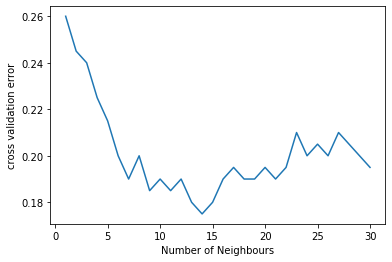

In [107]:
# Put your code here
import matplotlib.pyplot as plt
error=crossValidationkNN(traindata,trainlabels,30)
neigh=np.arange(1,31)
plt.plot(neigh,error)
plt.ylabel('cross validation error')
plt.xlabel('Number of Neighbours')



Select the number of neighbors which minimizes the cross-validation error. What is the cross-validation error for this number of neighbors? <b>(10 points)</b>

In [118]:
# Put your code here
minerror=np.min(error)

for i in range(1,30):
    if error[i]==minerror:
        numberneighbours=i
    
print('Number of Neighbours that minimize Cross validation error = ',numberneighbours)
print('least cross validation error = ',error[numberneighbours])

Number of Neighbours that minimize Cross validation error =  13
least cross validation error =  0.175


[Insert Answer Here]
13 neighbours minimizes cross validation error. 
Error for 13 neighbours = 0.175


Train a kNN model on the whole training data using the number of neighbors you found in the previous part of the question, and apply it to the test data. Is it higher or lower than the cross-validation error you found in the last part of the problem? **(10 points)**

In [119]:
# Put your code here
knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(traindata,trainlabels)
testest=knn.predict(testdata)
print('Error on test  data = ',classifierError(testest,testlabels))

Error on test  data =  0.22


[Insert Answer Here]
The  error on the test data for 13 neighbours was 0.22. this is about 4.5% higher than the cross validation error  for 13  neighbours.

### Problem 3: Detecting Cancer with SVMs and Logistic Regression (45 points)

We consider the [Breast Cancer Wisconsin Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) from 
W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993. 

The authors diagnosed people by characterizing 3 cell nuclei per person extracted from the breast (pictures [here](http://web.archive.org/web/19970225174429/http://www.cs.wisc.edu/~street/images/)), each with 10 features (for a 30-dimensional feature space):

1. radius (mean of distances from center to points on the perimeter) 

2. texture (standard deviation of gray-scale values) 

3. perimeter 

4. area 

5. smoothness (local variation in radius lengths) 

6. compactness (perimeter^2 / area - 1.0) 

7. concavity (severity of concave portions of the contour) 

8. concave points (number of concave portions of the contour) 

9. symmetry 

10. fractal dimension ("coastline approximation" - 1)

and classified the sample into one of two classes: Malignant ($+1$) or Benign ($-1$). You can read the original paper for more on what these features mean.

You will be attempting to classify if a sample is Malignant or Benign using Support Vector Machines, as well as Logistic Regression. Since we don't have all that much data, we will use 10-fold cross-validation to tune our parameters for our SVMs and Logistic Regression. We use 90% of the data for training, and 10% for testing.

You will be experimenting with SVMs using Gaussian RBF kernels through sklearn.svm.SVC, linear SVMs through sklearn.svm.LinearSVC, and sklearn.linear_model.LogisticRegression for Logistic Regression. 

Your model selection will be done with cross-validation via sklearn.model_selection's cross_val_score. This returns the accuracy for each fold, i.e. the fraction of samples classified correctly. Thus, the cross-validation error is simply 1-mean(cross_val_score).

First, we load the data. We will use scikit-learn's train test split function to split the data. The data is scaled for reasons outlined <a href="http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">here</a>. In short, it helps avoid some numerical issues and avoids some problems with certain features which are typically large affecting the SVM optimization problem unfairly compared to features which are typically small. 

In [ ]:
from sklearn.model_selection import train_test_split

cancer = genfromtxt('Data/wdbc.csv', delimiter=',')

np.random.seed(seed=282017) # seed the RNG for repeatability
idx=np.random.permutation(cancer.shape[0])
cancer=cancer[idx]

cancer_features=cancer[:,1:]
cancer_labels=cancer[:,0]

#The training data is in data_train with labels label_train. 
# The test data is in data_test with labels label_test.
data_train, data_test, label_train, label_test = train_test_split(cancer_features,cancer_labels,test_size=0.1,random_state=292017)

# Rescale the training data and scale the test data correspondingly
scaler=MinMaxScaler(feature_range=(-1,1))
data_train=scaler.fit_transform(data_train) #Note that the scaling is determined solely via the training data!
data_test=scaler.transform(data_test)

The soft margin linear SVM is tuned based on a parameter $C$, which controls how much points can be violating the margin (this isn't the same $C$ as in the notes, though it serves the same function; see the [scikit-learn documentation](http://scikit-learn.org/stable/modules/svm.html#svc) for details). 

Use cross-validation to select a value of $C$ for a linear SVM (sklearn.svm.LinearSVC) by varying $C$ from $2^{-5},2^{-4},\ldots,2^{15}$. 

Which value of $C$ would you choose, and why? What is the corresponding cross-validation error? <b>(10 points)</b>

In [201]:
#Put your code here
errtot=np.zeros(21)
for i in range(-5,16):
    cval=2**i
    sv=LinearSVC(C=cval)
    crosserr=model_selection.cross_val_score(sv,data_train,label_train,cv=10)
    errtot[i+5]=1-((np.sum(crosserr))/10)
x=np.min(errtot)
for j in  range(21):
    if errtot[j]==x:
        choose=j-5
print('Value of C that minimizes cross validation error =  ',2**choose)
print('This value of c produces a cross validation error = ',x)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Value of C that minimizes cross validation error =   0.125
This value of c produces a cross validation error =  0.02714932126696823


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

[Insert Answer Here]
I would choose the  value  of C = 0.125 or 2^(-3) as it is the value of c that minimizes the cross validation error.
It produces a cross validation error of 0.0271493212669682

You will now experiment with using kernels in an SVM, particularly the Gaussian RBF kernel (in sklearn.svm.SVC). The SVM has two parameters to tune in this case: $C$ (as before), and $\gamma$, which is a parameter in the RBF. 

Use cross-validation to select parameters $(C,\gamma)$ by searching varying $(C,\gamma)$ over $C=2^{-5},2^{-4},\ldots,2^{15}$ and $\gamma=2^{-15},\ldots,2^{3}$ [So, you will try about 400 parameter choices]. Out of these, which $(C,\gamma)$ parameters would you choose? What is the corresponding cross-validation error? 

This procedure is known as a *grid search*.We are using a fairly coarse grid for this problem, but one could use a finer grid once the rough range of good parameters is known (rather than starting with a fine grid, which would waste a lot of time). <b>(10 points)</b>

In [199]:
# Put your code here
errtot=np.zeros((21,19))
for i in range(-5,16):
    for g in range(-15,4):
        cval=2**i
        gval=2**g
        svc=SVC(C=cval,gamma=gval)
        crosserr=model_selection.cross_val_score(svc,data_train,label_train,cv=10)
        errtot[i+5,g+15]=1-((np.sum(crosserr))/10)
x=np.argmin(errtot)
bestg=(x%19)
bestc=int(((x-bestg)/19))
gau=bestg-15
realc=bestc-5
leasterr=np.min(errtot)
print('Value of C that minimizes cross validation error =  ',2**realc)
print('Value of gamma that minimizes cross validation error = 2^',gau)
print('These values of c and gamme produce a cross validation error = ',leasterr)

Value of C that minimizes cross validation error =   8
Value of gamma that minimizes cross validation error = 2^ -3
These values of c and gamme produce a cross validation error =  0.019457013574660564


[Insert Answer Here]
I would choose (C,gamma) = (2^3,2^-3)=(8,0.125) as this combinatiion gives me the least cross validation error of 0.019457013574660564


As stated in a footnote in the notes, Logistic Regression normally has a regularizer parameter to promote stability. Scikit-learn calls this parameter $C$ (which is like $\lambda^{-1}$ in the notes); see the [LibLinear](http://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf) documentation for the exact meaning of $C$. 

Use cross-validation to select a value of $C$ for logistic regression (sklearn.linear_model.LogisticRegression) by varying $C$ from $2^{-14},2^{-4},\ldots,2^{14}$. You may optionally make use of sklearn.model_selection.GridSearchCV, or write the search by hand (as before). 

Which value of $C$ would you choose? What is the corresponding cross-validation error? **(5 points)**

In [200]:
#Put your code here
errtot=np.zeros(29)
for i in range(-14,15):
    cval=2**i
    lr=LogisticRegression(C=cval)
    crosserr=model_selection.cross_val_score(lr,data_train,label_train,cv=10)
    errtot[i+14]=1-((np.sum(crosserr))/10)
x=np.min(errtot)
for j in  range(29):
    if errtot[j]==x:
        choose=j-14

print('Value of C that minimizes cross validation error =  ',2**choose)
print('This value of c produces a cross validation error = ',x)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

Value of C that minimizes cross validation error =   2
This value of c produces a cross validation error =  0.02714932126696823


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[Insert Answer Here]
The value of C that I would choose is C=2 or C=2^1.
This value of C produces the minimal cross validation error = 0.02714932126696823

Based on the classifiers you selected thusfar for Linear SVM, SVM + Gaussian RBF and Logistic Regression, which classifier would you pick? Make sure to take into account error, the application and computational considerations. **(5 points)**

[Insert Answer Here]
I will pick the SVM+Gaussian RBF classifier with C=8 and gamma=0.125 as it produces a cross validation error smaller than the other classifiers. Additionally, the svm+gaussian rbf classifier requires very simlar computational power when compared to the other classifiers.

Train the classifier selected above on the whole training set. Then, estimate the prediction error using the test set. What is your estimate of the prediction error? How does it compare to the cross-validation error?  <b>(10 points)</b>

In [208]:
#Put your code here
svc=SVC(C=8,gamma=0.125)
svc.fit(data_train,label_train)
testest=svc.predict(data_test)
prederr=classifierError(testest,label_test)
print('The prediction error on the test set for svm+gaussian rbf classifier = ',prederr)


The prediction error on the test set for svm+gaussian rbf classifier =  0.017543859649122806


[Insert Answer Here]
The prediction error on the test set for this classifier is 0.01754 while its cross  validation error was 0.01954.
Thus, the prediction error is very slightly smaller than the cross validation error.

Do you think the 0,1-loss is appropriate performance measure to report, in this case? If so, why? If not, how would you measure performance? **(5 points)**

[Insert Answer Here]
Yes, over here we only bother about weather the cell nuclei contain cancer characteristics or not. We evaluate this  based on 10 different features. Thus, 0-1 loss will give me an exact measure of how many nuclei were classified wrongly and that is all I need.

## And this concludes Lab 3! 